In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np

In [4]:
# Load data
data_dir = Path("../Data/")

cardio = pd.read_csv(data_dir / "Friday_DICT_direct_4o_cardiotoxicity_comprehensive.csv")
derm = pd.read_csv(data_dir / "Thursday_Derm_direct_4o_dermtoxicity_comprehensive.csv")
hema = pd.read_csv(data_dir / "Sunday_Hema_direct_4o_hematoxicity_final.csv")
inf = pd.read_csv(data_dir / "Thursday_Inf_direct_4o_inftoxicity_comprehensive.csv")
liver = pd.read_csv(data_dir / "Sunday_DILI_direct_4o_livertoxicity_final.csv")
oto = pd.read_csv(data_dir / "Thursday_Oto_direct_4o_ototoxicity_comprehensive.csv")
pulm = pd.read_csv(data_dir / "Sunday_Pulm_direct_4o_pulmtoxicity_final.csv")
renal = pd.read_csv(data_dir / "Sunday_DIRIL_direct_4o_renaltoxicity_final.csv")

# Relabel datasets
name_to_dataset = {
    "cardio_toxicity": cardio,
    "dermatologic_toxicity": derm,
    "hematotoxicity": hema,
    "infertility": inf,
    "liver_toxicity": liver,
    "ototoxicity": oto,
    "pulmonary_toxicity": pulm,
    "renal_toxicity": renal,
}

for name, data in name_to_dataset.items():
    name_to_dataset[name] = data[data["generic_name"] != "ALVIMOPAN"].copy()

for name, data in name_to_dataset.items():

    data.drop(columns=["Unnamed: 0", "initial_prompts", "no_less_most_prompts", "yes_no_prompts", "urls"], inplace=True)

    if "set_id" in data.columns:
        data.drop(columns="set_id", inplace=True)

    data.rename(columns={
        "reasoning": f"{name}_reasoning",
        "less_determination": f"{name}_less_determination",
        "binary_determination": f"{name}_binary_determination",
    }, inplace=True)

    data[f"{name}_less_determination_no_most_only_0_1"] = [1 if tox == "Most" else (0 if tox == "No" else np.nan) for tox in data[f"{name}_less_determination"]]
    data[f"{name}_binary_determination_0_1"] = [1 if tox == "Yes" else (0 if tox == "No" else np.nan) for tox in data[f"{name}_binary_determination"]]

# Merge datasets on generic name
datasets = list(name_to_dataset.values())
data = datasets[0]
for dataset in datasets[1:]:
    data = data.merge(dataset, on="generic_name")

In [5]:
tasks = list(name_to_dataset.keys())
task_map = {
    "cardio_toxicity": "Cardiotoxicity",
    "dermatologic_toxicity": "Dermatological Toxicity",
    "hematotoxicity": "Hematological toxicity",
    "infertility": "Infertility",
    "liver_toxicity": "Liver Toxicity",
    "ototoxicity": "Ototoxicity",
    "pulmonary_toxicity": "Pulmonary Toxicity",
    "renal_toxicity": "Renal Toxicity",
}
tasks = [task_map[task] for task in tasks]

## Fig 1

In [6]:
sns.set(style="whitegrid")
# make figures high res
plt.rcParams['figure.dpi'] = 300

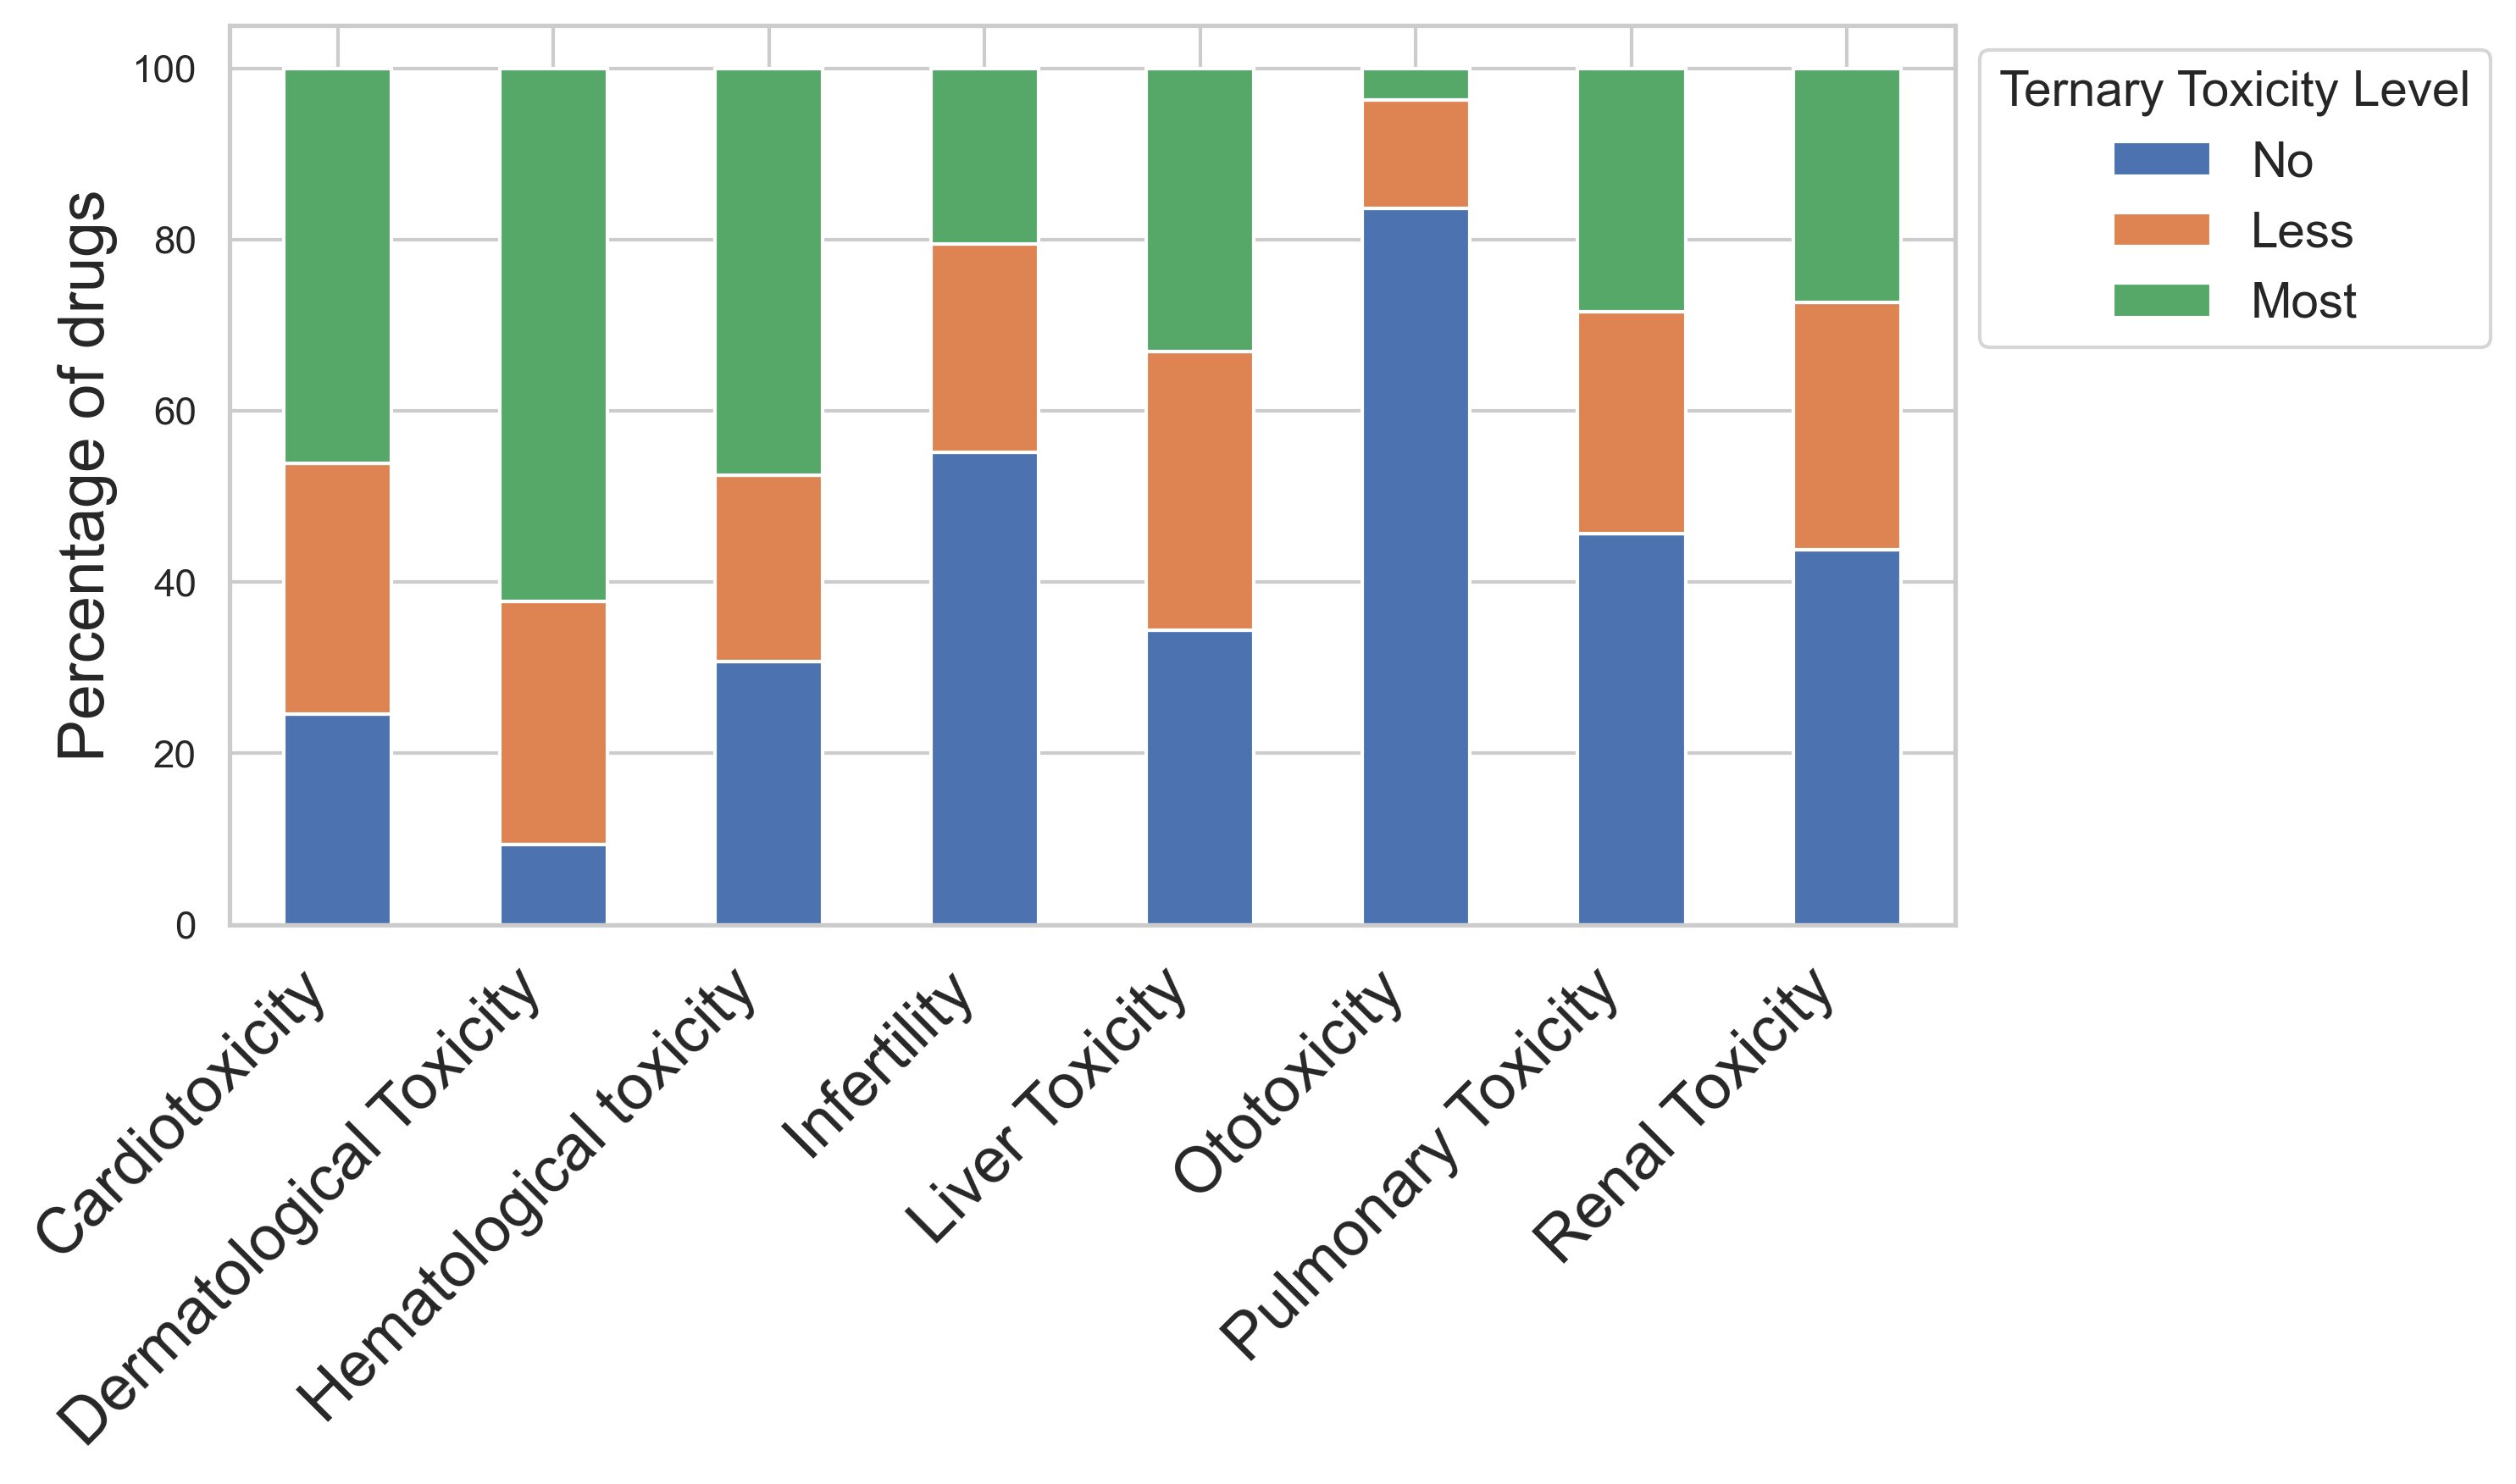

In [7]:
class_balances = pd.DataFrame()
for tox in name_to_dataset.keys():
    # calculate the percentage of each toxicity labeled no/less/most and add to a df
    tox_determination = data[f"{tox}_less_determination"]
    # remove "." from the any of any labels
    data[f"{tox}_less_determination"] = tox_determination.str.replace(".", "", regex=False)
    class_balances[tox] = data[f"{tox}_less_determination"].value_counts(normalize=True) * 100

class_balances = class_balances.T

# make a stacked bar plot in the order of no less most from bottom to top
class_balances = class_balances[["No", "Less", "Most"]]
class_balances.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.legend(title="Ternary Toxicity Level", fontsize=14, title_fontsize=14, bbox_to_anchor=(1, 1))
# plt.xlabel("Toxicity", fontsize=20)
plt.ylabel("Percentage of drugs", fontsize=18)
# increase xticklabel size
# replace xticklabels with the names of the toxicities
ax = plt.gca()
ax.set_xticklabels(tasks, fontsize=18, rotation=45, ha="right")
# save the figure
plt.tight_layout()
plt.savefig("figures/class_balance_ternary.pdf")

## Fig 2

In [8]:
# Load the data
zaniar = pd.read_excel(data_dir / "uniTox_ratings_to_be_scored_Zaniar.xlsx", sheet_name=None)
angela = pd.read_excel(data_dir / "uniTox_ratings_to_be_scored_Angela.xlsx", sheet_name=None)
name_to_data = {
    "Clinician 1": angela,
    "Clinician 2": zaniar,
}
toxicities = list(angela.keys())

In [10]:
name_mapping = {
    "Dermatologic": "Dermatological Toxicity",
    "Hematotoxicity": "Hematological Toxicity",
    "Pulmonary": "Pulmonary Toxicity",
    "Renal toxicity": "Renal Toxicity",
    "Infertility": "Infertility",
    "Ototoxicity": "Ototoxicity",
}

Ternary Rating
{1: array([87, 76, 96, 92, 90]), 2: array([12, 12,  3,  7,  5]), 3: array([ 1, 12,  1,  1,  4])}
Binary Determination
{1: array([98, 81, 95, 97, 91]), 2: array([2, 7, 5, 2, 6]), 3: array([ 0, 12,  0,  1,  2])}


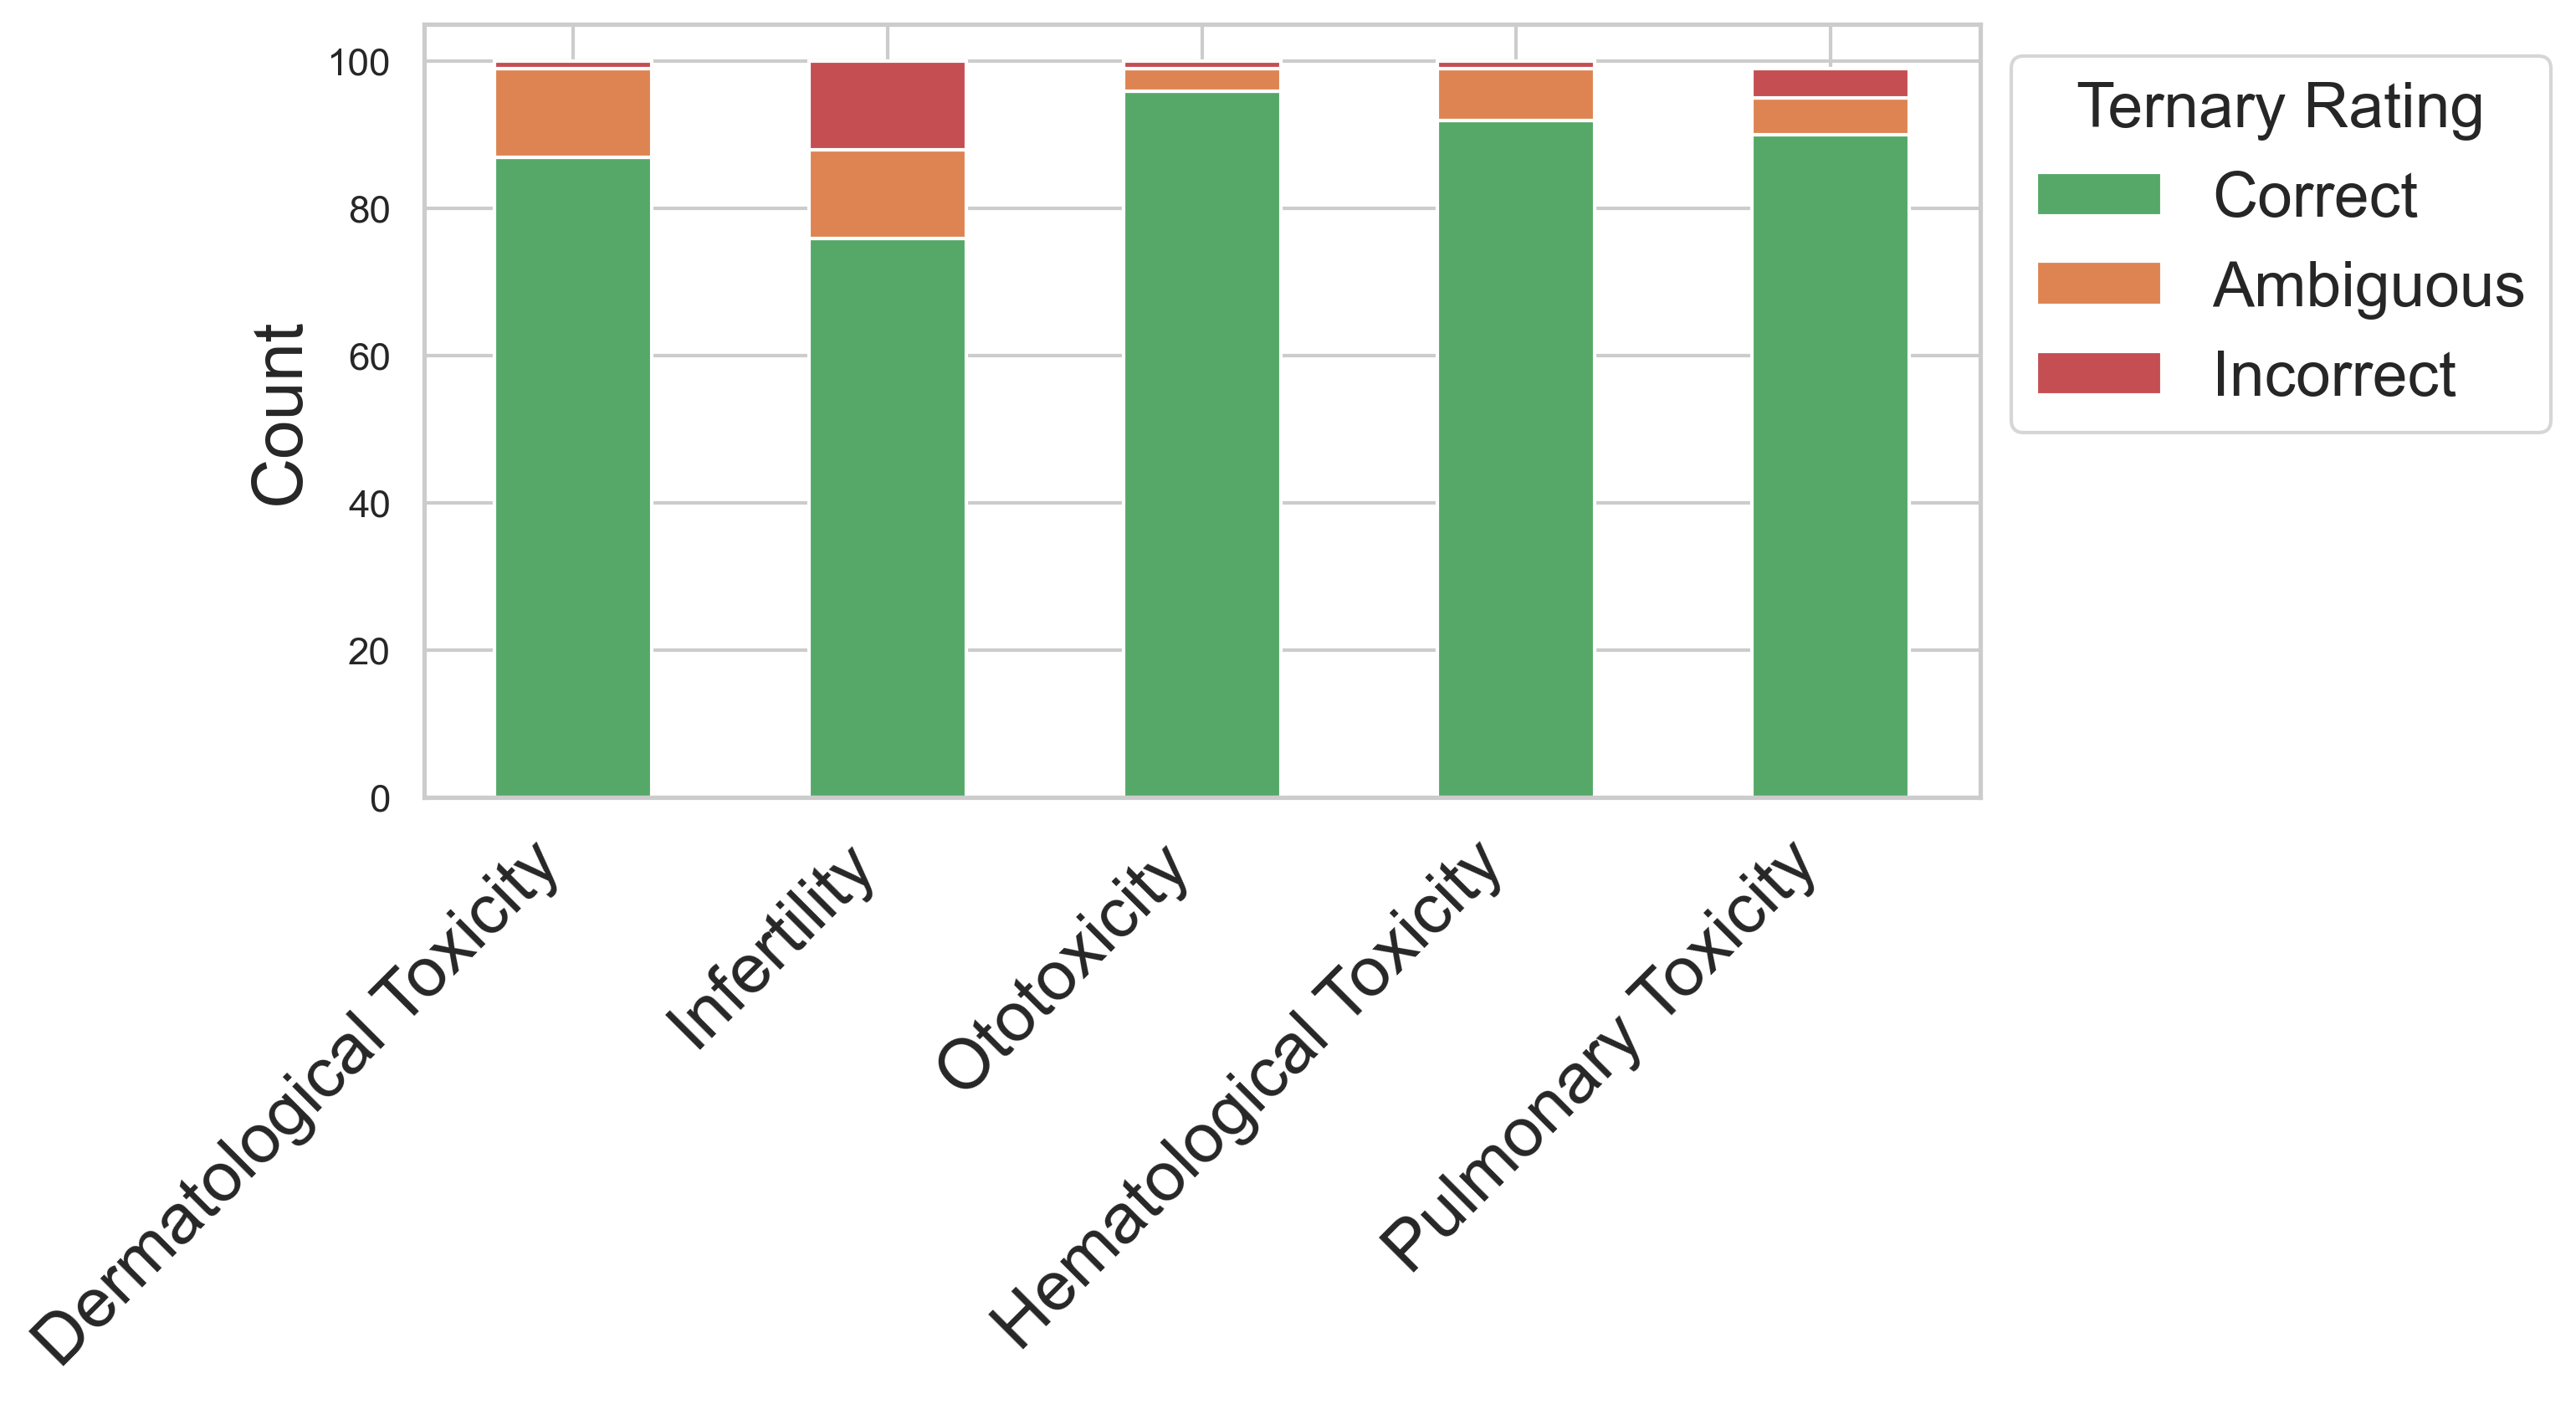

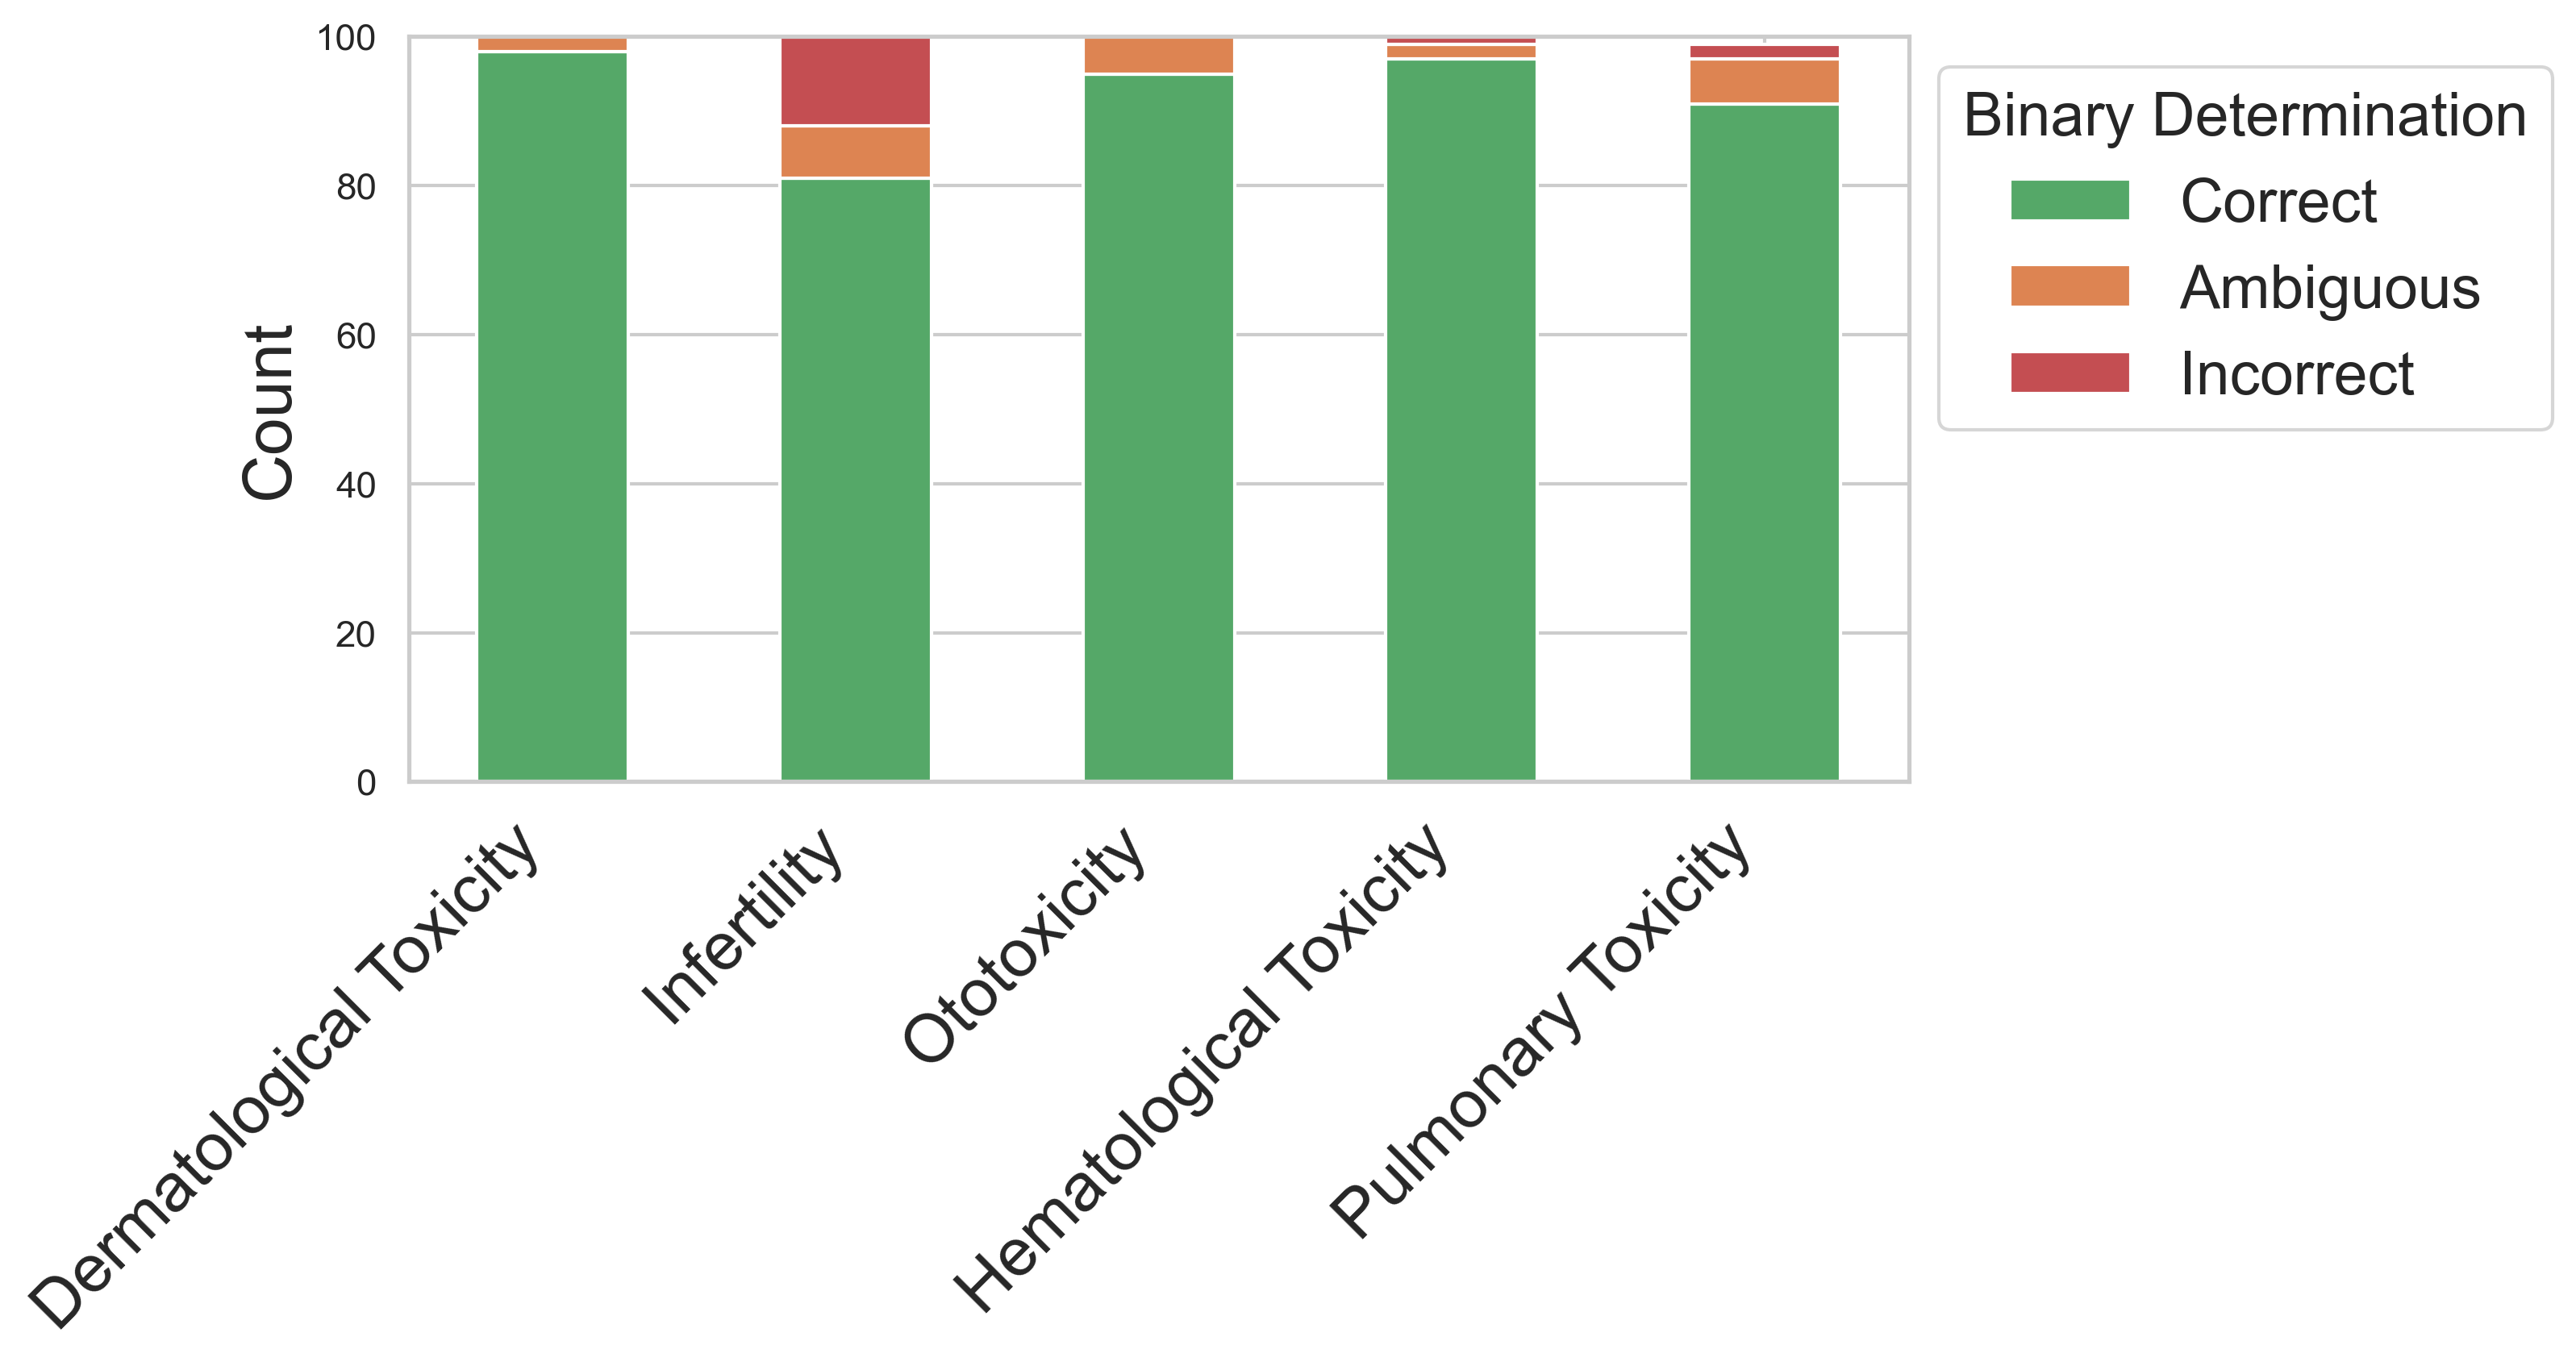

In [11]:
# For each person, create a stacked bar plot of the counts of less_determination_score and binary_determination_score
score_type_to_name = {
    "less_determination_score": "Ternary Rating",
    "binary_determination_score": "Binary Determination",
}

for score_type, score_name in score_type_to_name.items():
    fig, ax = plt.subplots(figsize=(8, 4))

    # Define the bar width
    bar_width = 0.5
    num_tox = 5

    # Get the x locations for the groups
    x_axis = np.arange(num_tox)

    # Plot each method's bar on top of the previous one
    bottom = np.zeros(num_tox)
    scores = [1, 2, 3]
    labels = ["Correct", "Ambiguous", "Incorrect"]
    colors = [sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[3]]

    score_nums = {
        score: np.array([
            (angela[tox_type][score_type] == score).sum(axis=0) + (zaniar[tox_type][score_type] == score).sum(axis=0)
            for tox_type in toxicities
        ]) for score in scores
    }

    for score, label, color in zip(scores, labels, colors):
        ax.bar(x_axis, score_nums[score], bottom=bottom, width=bar_width, label=label, color=color)
        bottom += score_nums[score]

    # Rotate x-ticks diagonally
    ax.set_xticks(x_axis)
    ax.set_xticklabels([name_mapping[x] for x in toxicities], rotation=45, ha='right', fontsize=20)


    # Add labels and title
    ax.set_ylabel("Count", fontsize=20)
    # ax.set_title(f"Clinician {score_name} Scores")
    ax.legend(title=score_name, fontsize=18, title_fontsize=18, bbox_to_anchor=(1, 1))

    # Show the plot

    # plt.show()
    plt.savefig(f"figures/clinician_{score_name.lower().replace(' ', '_')}.pdf", bbox_inches="tight")
    # plt.close()

    print(score_name)
    print(score_nums)

## figure 3

In [12]:
n_tox_per_drug = pd.read_csv("data/histogram_tox_counts.csv", skiprows=1, names=["number_of_toxicities_per_drug", "number_of_drugs"])

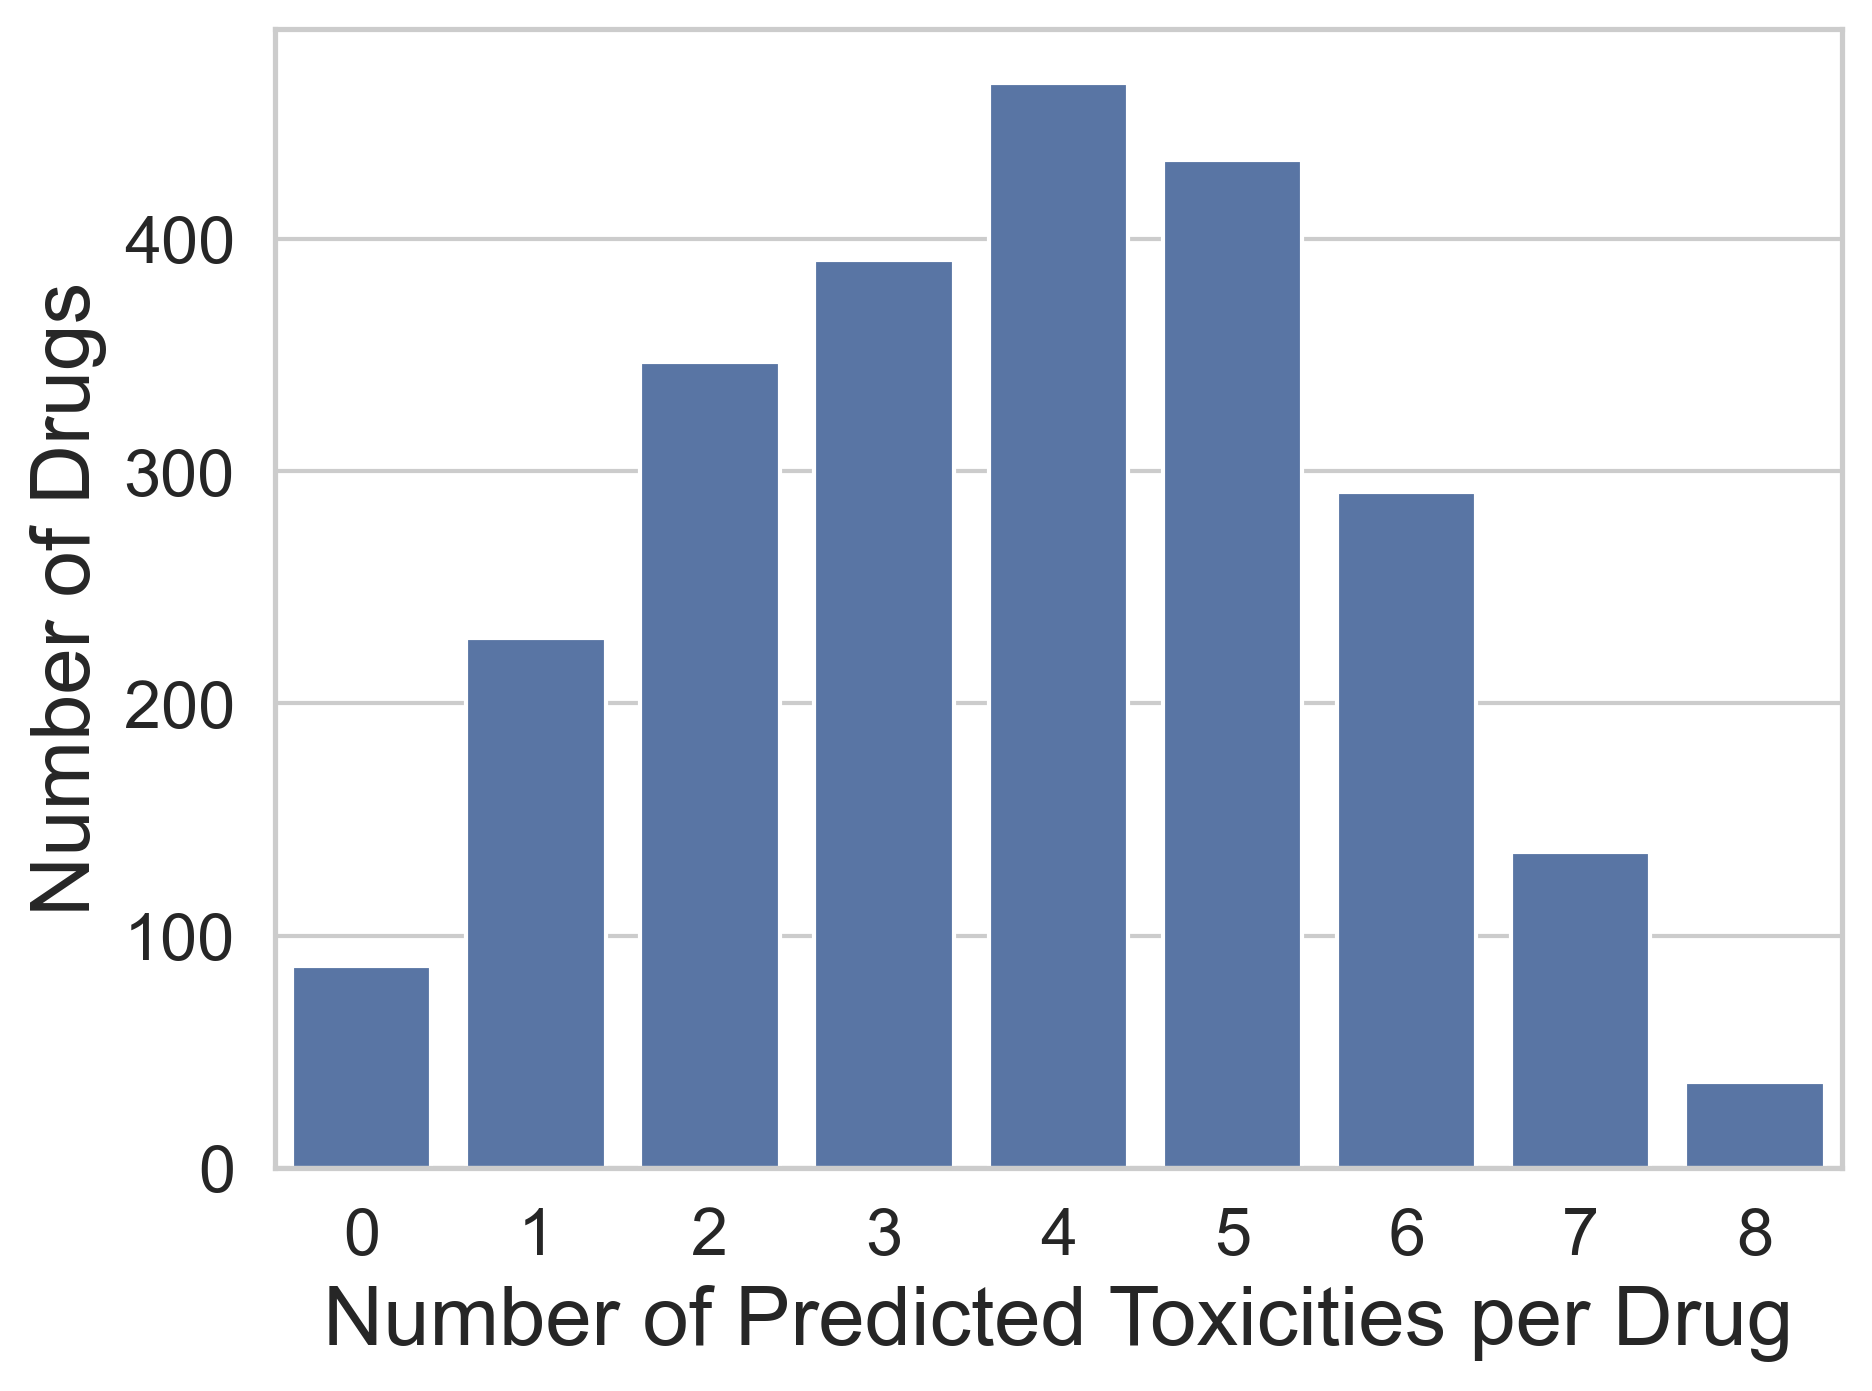

In [13]:
sns.barplot(x="number_of_toxicities_per_drug", y="number_of_drugs", data=n_tox_per_drug, color=sns.color_palette()[0])
plt.xlabel("Number of Predicted Toxicities per Drug", fontsize=20)
plt.ylabel("Number of Drugs", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("figures/histogram_tox_counts.pdf")

In [16]:
tox_corrs = pd.read_csv("data/corr_heatmap.csv", index_col=0)

In [14]:
task_map_for_heatmap = {
    "DICT": "Cardiotoxicity",
    "Derm": "Dermatological Toxicity",
    "Hema": "Hematological toxicity",
    "Inf": "Infertility",
    "DILI": "Liver Toxicity",
    "Oto": "Ototoxicity",
    "Pulm": "Pulmonary Toxicity",
    "DIRIL": "Renal Toxicity",
}


In [17]:
# change columns and rows based on task_map_for_heatmap
tox_corrs = tox_corrs.rename(columns=task_map_for_heatmap, index=task_map_for_heatmap)

# reindex based on tasks
tox_corrs = tox_corrs.reindex(index=tasks, columns=tasks)

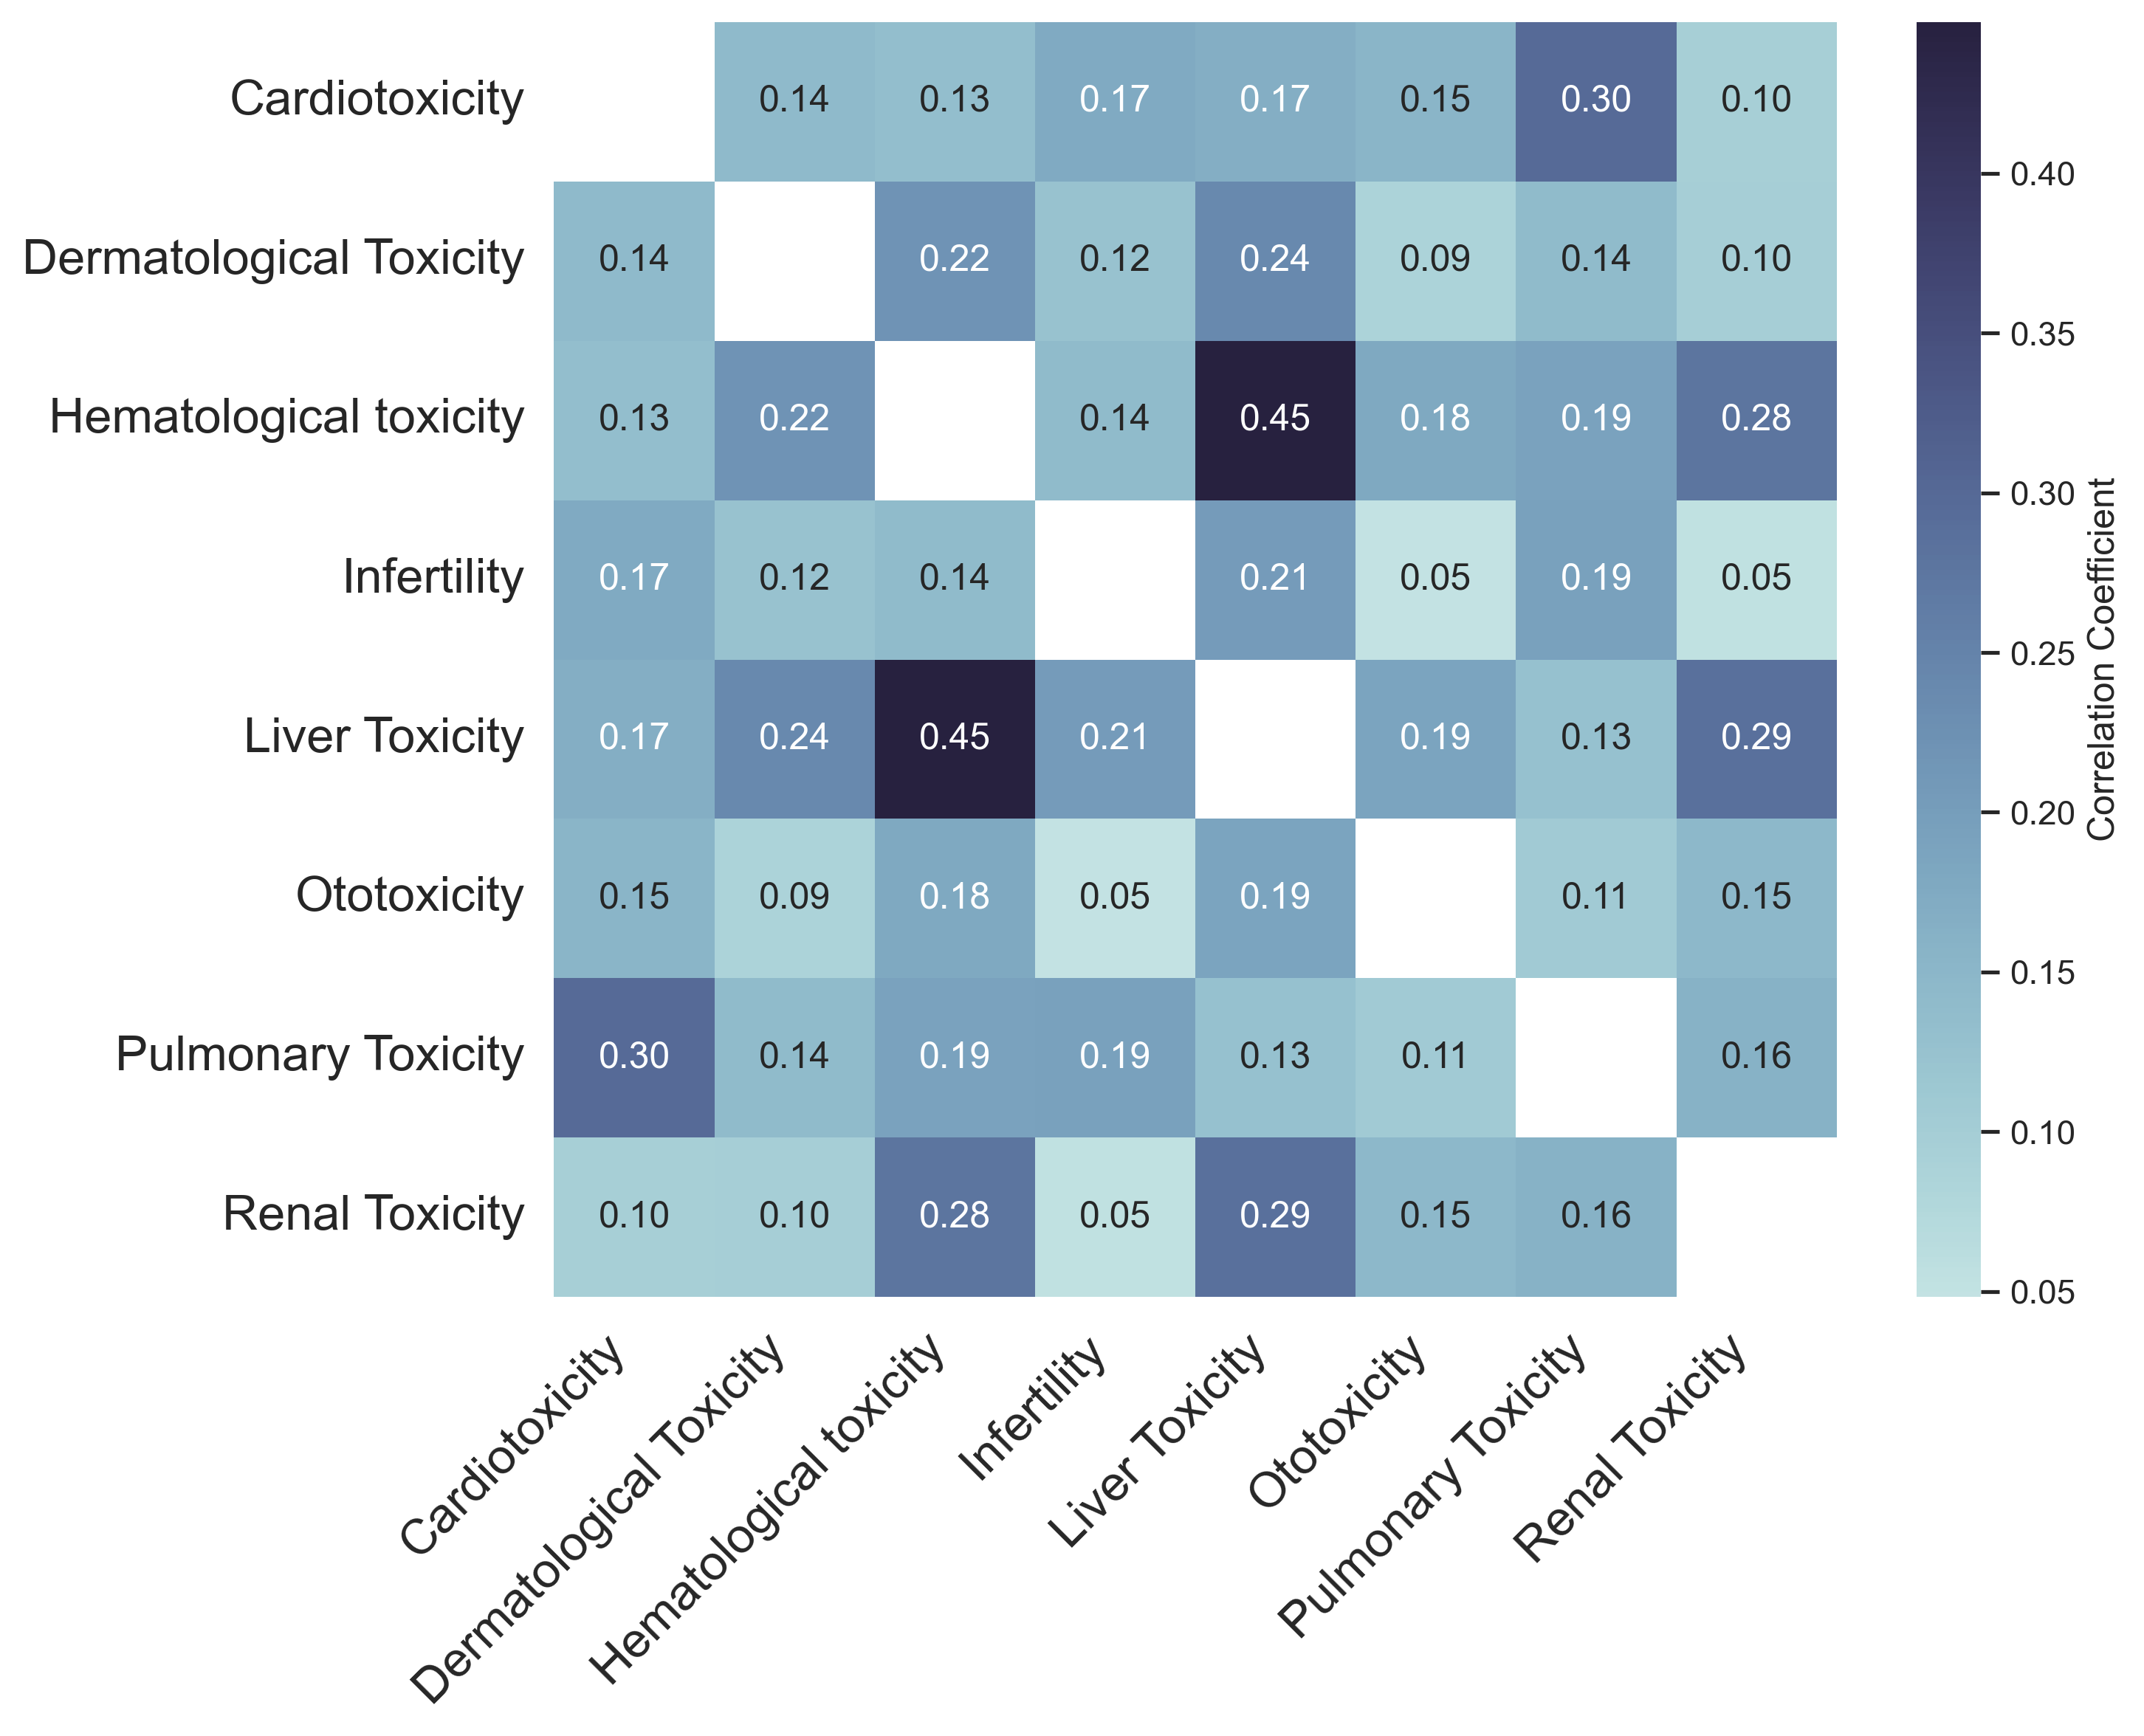

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(tox_corrs, annot=True, fmt=".2f", cbar_kws={"label": "Correlation Coefficient"},
            # cmap = sns.color_palette("Blues", as_cmap=True))
            # cmap=sns.color(sns.color_palette()[0], as_cmap=True,))
            cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
# set xtikcs and yticks to be tasks based on the task_map_for_heatmap
ax = plt.gca()
ax.set_xticklabels(tox_corrs.columns, fontsize=16, rotation=45, ha="right")
ax.set_yticklabels(tox_corrs.index, fontsize=16, rotation=0, ha="right")
plt.tight_layout()
plt.savefig("figures/corr_heatmap.pdf")

## figure 4

In [21]:

chemprop_less_scaffold = pd.read_csv(data_dir / "model_results/chemprop_rdkit_less_determination_no_most_only_0_1_scaffold_balanced/test_scores.csv")
chemprop_binary_scaffold = pd.read_csv(data_dir / "model_results/chemprop_rdkit_binary_determination_0_1_scaffold_balanced/test_scores.csv")

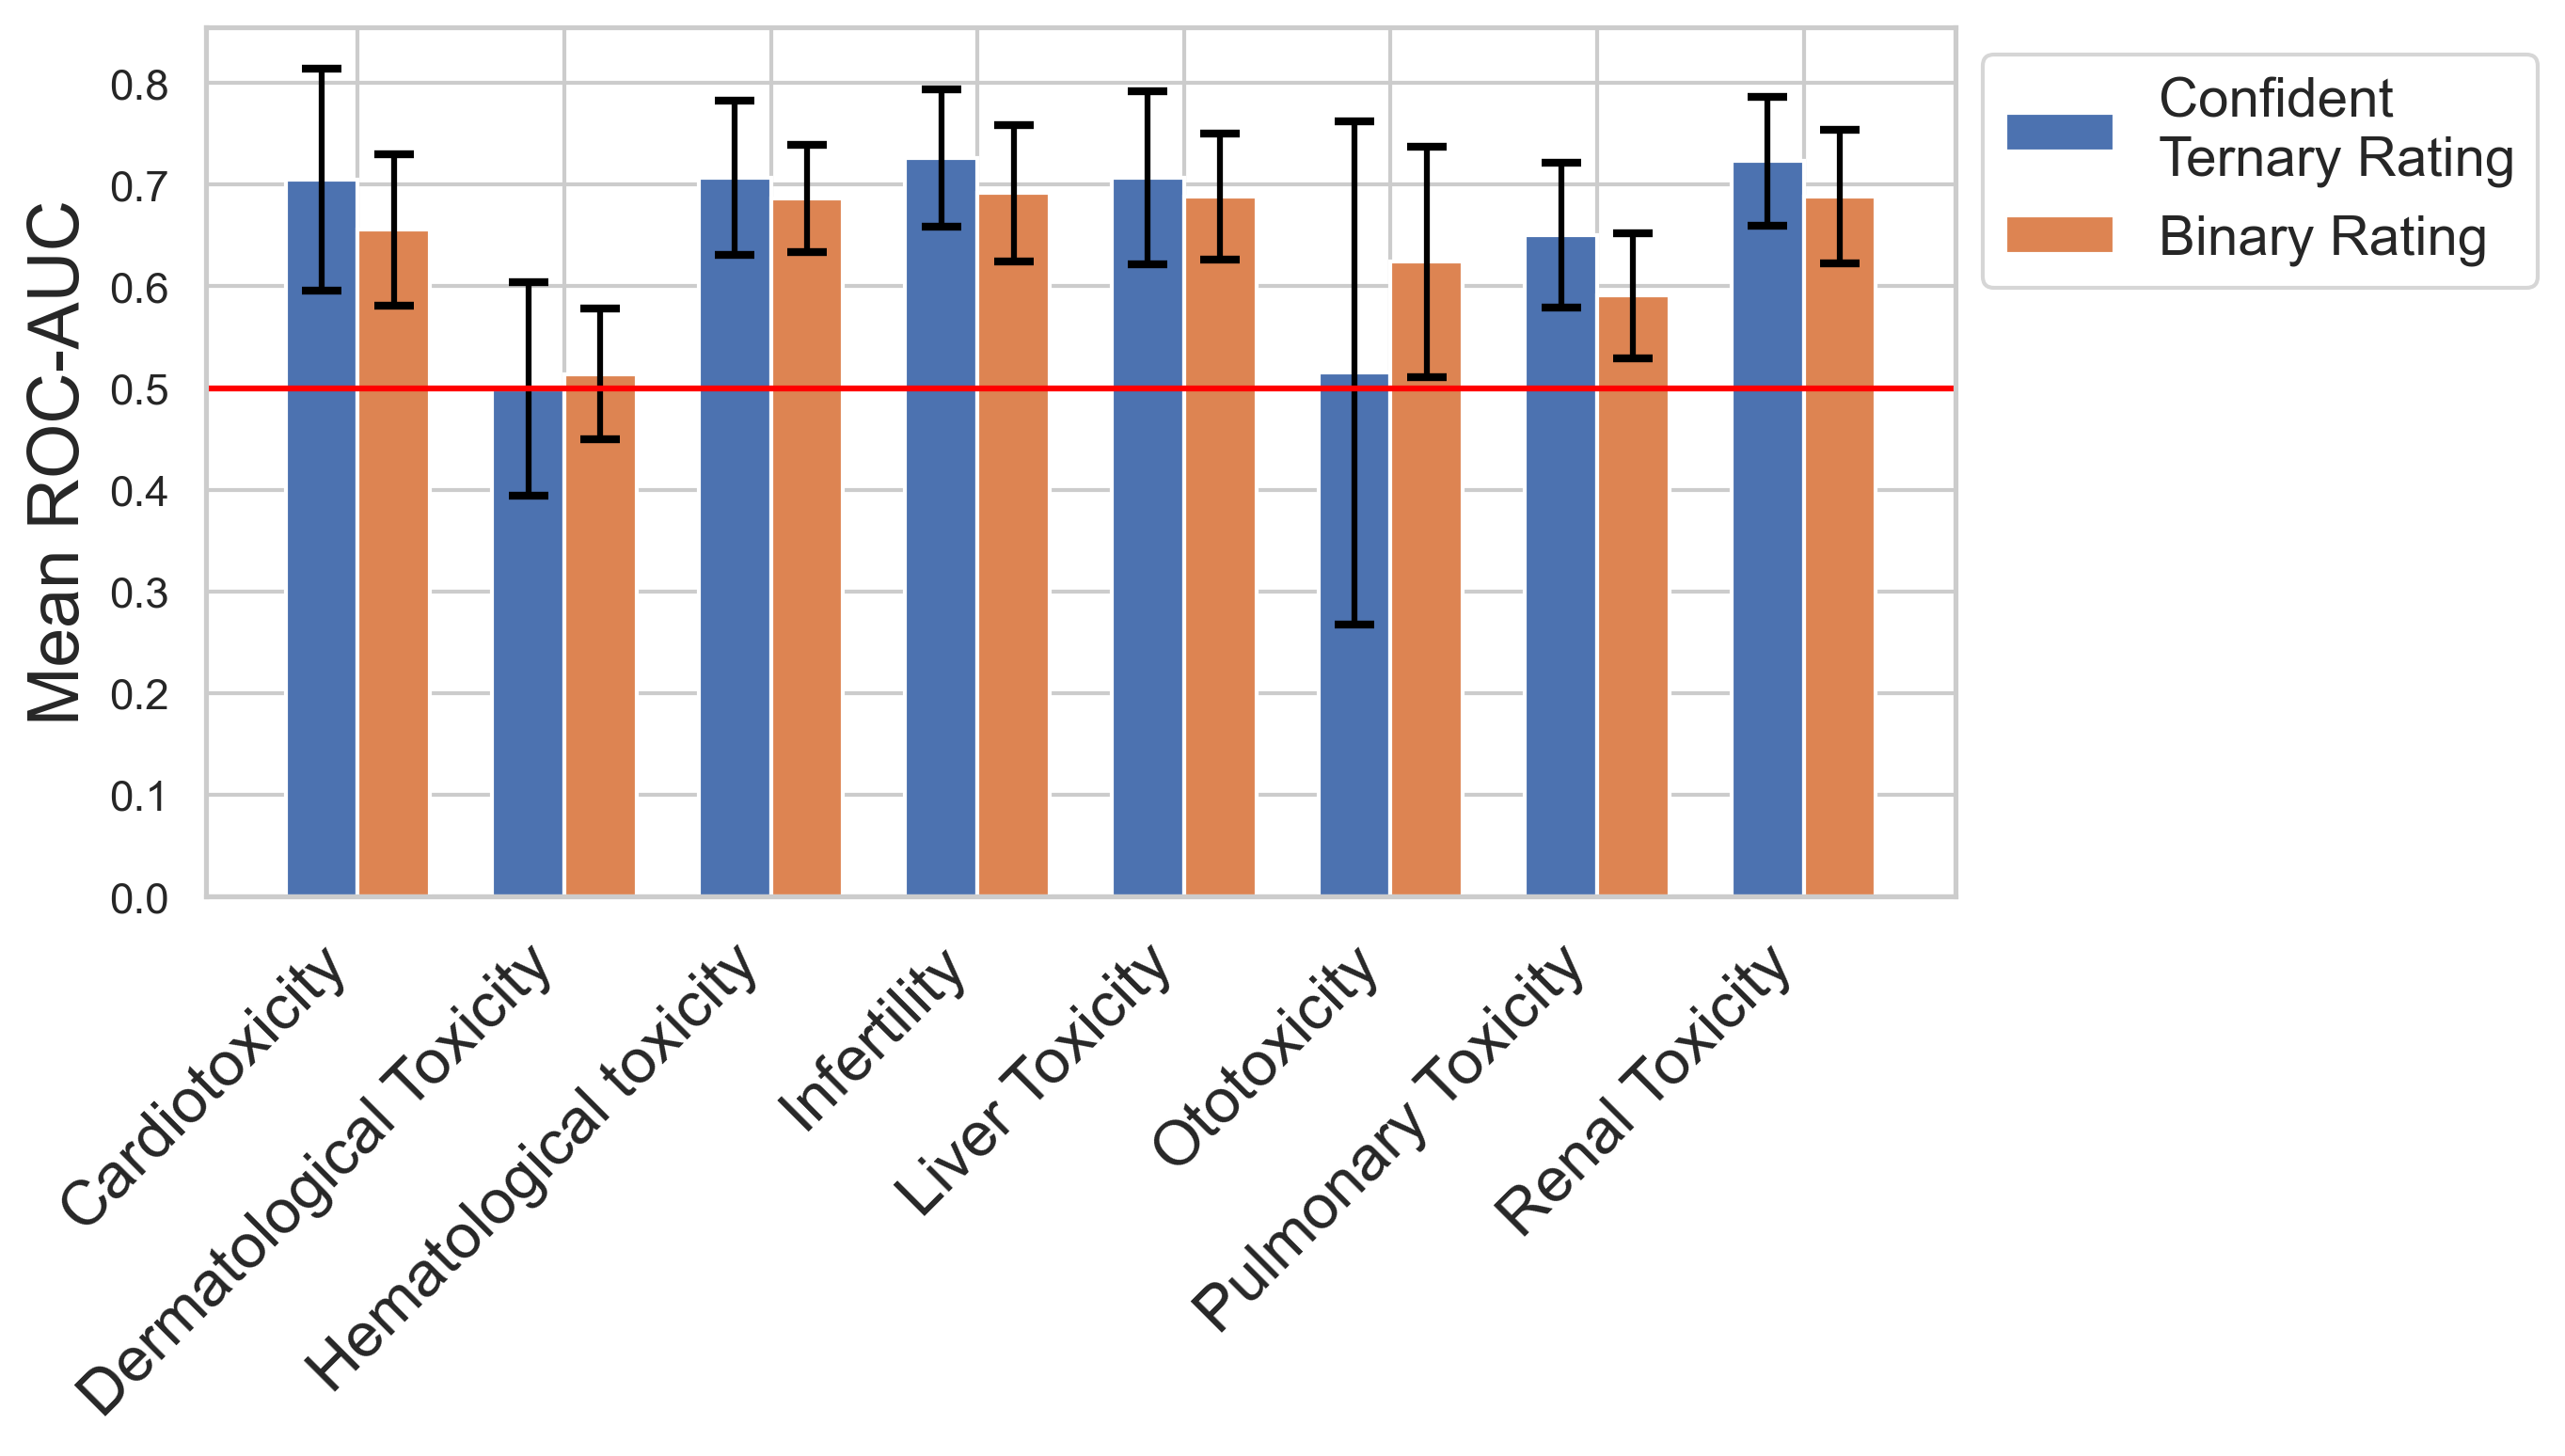

In [23]:
# Now plot both the chemprop less scaffold and chemprop binary scaffold on the same plot with side-by-side bar plots
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
bar_width = 0.35
x_axis = np.arange(len(chemprop_less_scaffold))
ax.bar(x_axis, chemprop_less_scaffold["Mean auc"], bar_width, label="Confident \nTernary Rating")
ax.bar(x_axis + bar_width, chemprop_binary_scaffold["Mean auc"], bar_width, label="Binary Rating")
ax.errorbar(x=x_axis,
            y=chemprop_less_scaffold["Mean auc"],
            yerr=chemprop_less_scaffold["Standard deviation auc"],
            fmt='none',  # No markers
            ecolor='black',  # Color of the error bars
            capsize=5,  # Length of the error bar caps
            capthick=2)  # Thickness of the error bar caps
ax.errorbar(x=x_axis + bar_width,
            y=chemprop_binary_scaffold["Mean auc"],
            yerr=chemprop_binary_scaffold["Standard deviation auc"],
            fmt='none',  # No markers
            ecolor='black',  # Color of the error bars
            capsize=5,  # Length of the error bar caps
            capthick=2)  # Thickness of the error bar caps
# ax.set_title("Scaffold Split")
ax.set_xticks(x_axis + bar_width / 2)
ax.set_xticklabels([x.replace("Hematotoxicity", "Hematological toxicity") for x in tasks], rotation=45, ha="right", fontsize=16)
ax.legend(fontsize=14, bbox_to_anchor=(1, 1))
ax.set_ylabel("Mean ROC-AUC", fontsize=18)
ax.axhline(0.5, color="red")
plt.savefig("figures/chemprop_scaffold.pdf", bbox_inches="tight")